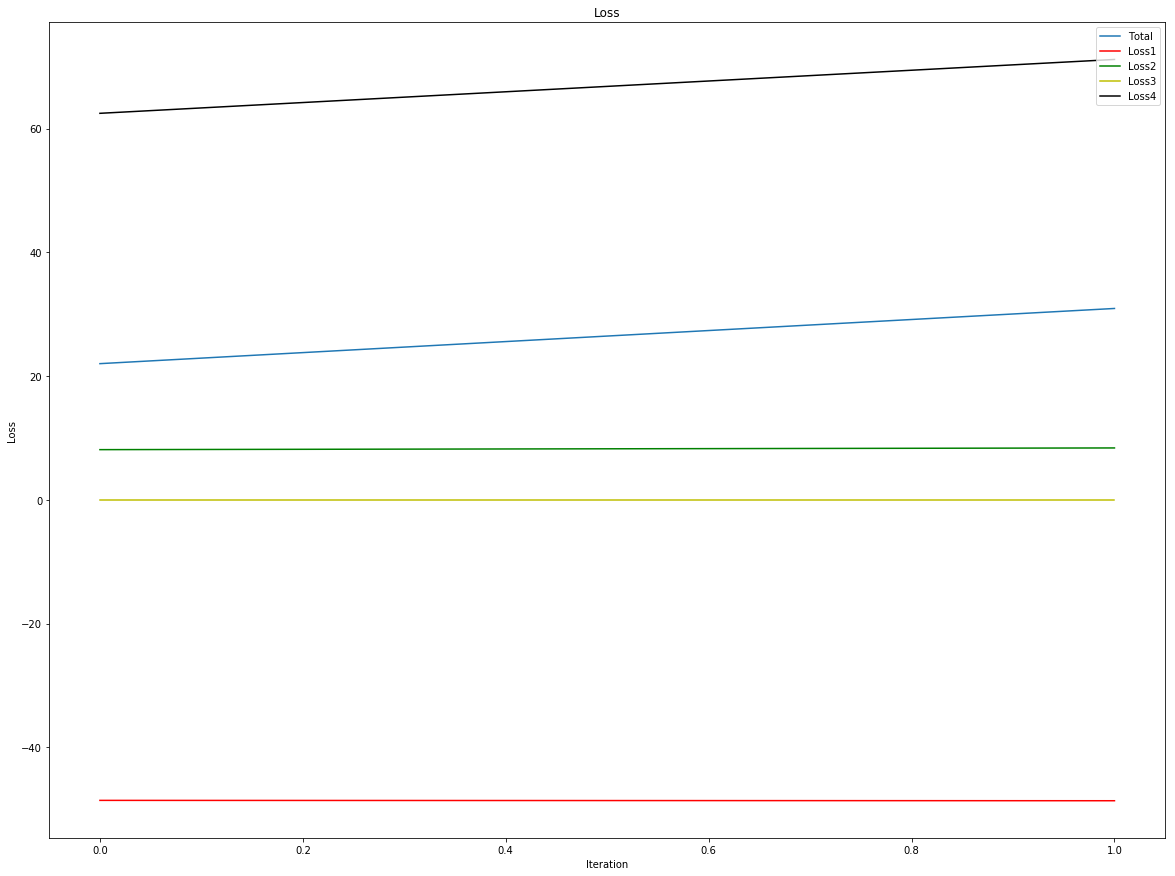

In [21]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt
import torch

dirname = 'results'

losses = pickle.load(open(dirname+'/loss.pkl', 'rb'))
losses = np.array(losses)
# print(losses)
N_iters = losses.shape[0]

# Plot total loss
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.show()

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(range(N_iters), losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

In [25]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'epochs': 5,
 'lambdas': (1000, 1, 0, 0.2),
 'learning_rate': 1e-05,
 'loss2_margin': 1,
 'multiplier': 0.001,
 'n_processes': 5,
 'nb_data': 5,
 'scoring_hidden_size': 100}


FileNotFoundError: [Errno 2] No such file or directory: 'results/runtime.pkl'

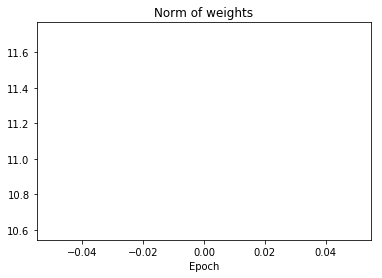

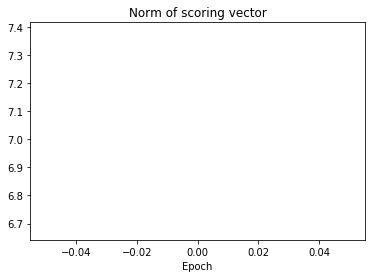

In [24]:
# Display weight magnitudes

epochs = params['epochs']
magnitudes = np.zeros(epochs)
scoring = np.zeros(epochs)
for i in range(epochs):
    weights = torch.load(dirname + '/epoch_' + str(i + 1) + '.pt')
    for weight in weights:
        magnitudes[i] += weights[weight].norm()
        if 'scoring' in weight:
            scoring[i] += weights[weight].norm()

plt.figure()
plt.plot(range(epochs), magnitudes, 'g')
plt.title('Norm of weights')
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.plot(range(epochs), scoring, 'r')
plt.title('Norm of scoring vector')
plt.xlabel('Epoch')
plt.show()